# The battle of Neighborhoods

## Background

The third-party delivery industry has been growing exponentially in recent years due to technology adoption. Nowadays, this service industry is based on mobile apps in which a client orders a product from the business listed and a delivery man picks up the items from a store and transports it to the clients addresses while receiving part of the fee charged for the service. 

## Problem

Orders are mostly accepted by the delivery man closest to the business selected by the client, because this means he has to invest the least amount of resources to get to the item, hence, he keeps a bigger profit from the fee. In order to have a substantial income from this activity, the delivery man has to carefully select the area in which he should be located to accept more orders without having to spend too many resources to get to the selected items. This project will propose which areas and times could be the most profitable for a delivery man based on the venue density and top visit hours, because it's inferred that these are also the top hours for take out orders, all this for venues in Manhattan. 

## Data

Only Manhattan will be analyzed in this project. We will analyze its neighborhoods venue density by using the coordinates of each neighborhood, available here https://cocl.us/new_york_dataset, and use them as input to request the venues information available through Foursquare API. The data will be cleansed and wrangled in order to provide a dataframe that will be used for segmentation and clustering of the neighborhoods. The clusters will show which neighborhoods have more food business which will indicate a higher opportunity for the delivery man. 

So with said, lets import all the libraries needed for exploring and formating the data.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

In [2]:
from folium import plugins

Lets download the data from our source.

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


Now, we turn the data into a pandas dataframe.

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

This would be our dataframe for New York Neighborhoods:

In [5]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Lets visualiza the data on a Map using Folium tool:

The scope of this project will only include venues in Manhattan, so lets slice the original dataframe and create a new one with only Manhattan data.

In [6]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


The data visualized on a map by using Folium tool looks like this:

In [7]:
#Coordinates for Manhattan
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

We will use Foursquare API to explore the venues around our Neighborhoods.

In [8]:
# @hidden_cell
#Foursquare Credentials
CLIENT_ID = 'WHVMUALCKO1K0SRXRZ14PQWEE0AG23A33NQGL0PFZKMFG311' # your Foursquare ID
CLIENT_SECRET = 'LECHU10TPTWHFEFZQKSVE5H2BQ53EICQGOOQHK2KEKBQE0EO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [130]:
#Fuction to explore venues
def getNearbyVenues(names, latitudes, longitudes, LIMIT=100, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [131]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [132]:
#Create dataframe for Manhattan venues
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )


Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [12]:
print(manhattan_venues.shape)
manhattan_venues.head()


(2968, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


## Analyzing Neighborhoods

Analyzing each neighborhood, we will modify the dataframe to show the frequency of each venue category per neighborhood.

In [13]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center

In [14]:
#Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [15]:
#new dataframe with top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Boat or Ferry,Memorial Site,Italian Restaurant,Gourmet Shop,Burger Joint,Food Court,Shopping Mall
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Pizza Place,Bar,Bookstore,Gym,Gym / Fitness Center,Japanese Restaurant,Italian Restaurant
2,Central Harlem,Chinese Restaurant,Gym / Fitness Center,African Restaurant,American Restaurant,Bar,Cosmetics Shop,French Restaurant,Seafood Restaurant,Café,Market
3,Chelsea,Art Gallery,Coffee Shop,Italian Restaurant,Seafood Restaurant,Ice Cream Shop,Cupcake Shop,Café,Bakery,Market,Juice Bar
4,Chinatown,Bakery,Chinese Restaurant,Cocktail Bar,Optical Shop,Salon / Barbershop,American Restaurant,Spa,Bar,Coffee Shop,Pizza Place


This last dataframe will be used to cluster the neighborhoods according to how much they have in common. The objective is to determine Neighborhoods with high restaurant/bar/coffee density.

## Clustering Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [16]:
# set number of clusters
kclusters = 10

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 1, 6, 0, 3, 6, 8, 3, 1, 6], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [17]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,7,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Seafood Restaurant,Pizza Place,Department Store
1,Manhattan,Chinatown,40.715618,-73.994279,3,Bakery,Chinese Restaurant,Cocktail Bar,Optical Shop,Salon / Barbershop,American Restaurant,Spa,Bar,Coffee Shop,Pizza Place
2,Manhattan,Washington Heights,40.851903,-73.936900,3,Café,Bakery,Chinese Restaurant,Mobile Phone Shop,Grocery Store,Coffee Shop,Supermarket,Latin American Restaurant,Gym,Supplement Shop
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Bakery,Pizza Place,Restaurant,Café,Lounge,Park,Chinese Restaurant,Frozen Yogurt Shop,Deli / Bodega
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Cocktail Bar,Indian Restaurant,Sushi Restaurant,Yoga Studio,Chinese Restaurant


Finally, let's visualize the resulting clusters.

In [18]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Lets review each cluster now. I divided the dataframe into 10 clusters trying to make it easier to determine which cluster has more deliverable food type of restaurant, and discard those with hotels, parks, bars, shops, concert halls, cinemas, etc. 

In [19]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Chelsea,Art Gallery,Coffee Shop,Italian Restaurant,Seafood Restaurant,Ice Cream Shop,Cupcake Shop,Café,Bakery,Market,Juice Bar


In [20]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Upper East Side,Italian Restaurant,Bakery,Exhibit,Gym / Fitness Center,Spa,American Restaurant,Juice Bar,Pizza Place,Yoga Studio,Wine Shop
9,Yorkville,Coffee Shop,Italian Restaurant,Gym,Sushi Restaurant,Bar,Deli / Bodega,Wine Shop,Pizza Place,Mexican Restaurant,Diner
10,Lenox Hill,Italian Restaurant,Coffee Shop,Pizza Place,Sushi Restaurant,Café,Cocktail Bar,Burger Joint,Gym,Gym / Fitness Center,Bakery
12,Upper West Side,Italian Restaurant,Wine Bar,Coffee Shop,Bakery,Bar,Middle Eastern Restaurant,Bagel Shop,Mediterranean Restaurant,Indian Restaurant,Ice Cream Shop
16,Murray Hill,Sandwich Place,Chinese Restaurant,Gym / Fitness Center,Pizza Place,Sushi Restaurant,Hotel,Bar,Liquor Store,Burger Joint,Japanese Restaurant
18,Greenwich Village,Italian Restaurant,Coffee Shop,Café,Sushi Restaurant,Wine Bar,Dessert Shop,Chinese Restaurant,Gym,Jazz Club,Gourmet Shop
19,East Village,Pizza Place,Coffee Shop,Juice Bar,Cocktail Bar,Vietnamese Restaurant,Bar,Japanese Restaurant,Filipino Restaurant,Mexican Restaurant,Bagel Shop
22,Little Italy,Italian Restaurant,Chinese Restaurant,Spa,Pizza Place,Mediterranean Restaurant,Bakery,Thai Restaurant,Café,Bubble Tea Shop,Cosmetics Shop
23,Soho,Italian Restaurant,Coffee Shop,Mediterranean Restaurant,Dessert Shop,Art Gallery,Gym,French Restaurant,Café,Clothing Store,Jewelry Store
24,West Village,Wine Bar,Italian Restaurant,New American Restaurant,Park,Coffee Shop,American Restaurant,Seafood Restaurant,Cycle Studio,Steakhouse,Jazz Club


In [21]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Roosevelt Island,Park,Playground,Gym,Farmers Market,Food & Drink Shop,Pizza Place,Soccer Field,Supermarket,Metro Station,School
35,Turtle Bay,Italian Restaurant,Park,Café,Coffee Shop,Hotel,Sushi Restaurant,Wine Bar,Deli / Bodega,French Restaurant,American Restaurant
36,Tudor City,Café,Park,Deli / Bodega,Gym / Fitness Center,Mexican Restaurant,Pizza Place,Greek Restaurant,Garden,Dog Run,Diner


In [22]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Bakery,Chinese Restaurant,Cocktail Bar,Optical Shop,Salon / Barbershop,American Restaurant,Spa,Bar,Coffee Shop,Pizza Place
2,Washington Heights,Café,Bakery,Chinese Restaurant,Mobile Phone Shop,Grocery Store,Coffee Shop,Supermarket,Latin American Restaurant,Gym,Supplement Shop
3,Inwood,Mexican Restaurant,Bakery,Pizza Place,Restaurant,Café,Lounge,Park,Chinese Restaurant,Frozen Yogurt Shop,Deli / Bodega
4,Hamilton Heights,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Cocktail Bar,Indian Restaurant,Sushi Restaurant,Yoga Studio,Chinese Restaurant
5,Manhattanville,Coffee Shop,Seafood Restaurant,Italian Restaurant,Deli / Bodega,Park,Mexican Restaurant,Café,Bike Trail,Sushi Restaurant,Boutique
7,East Harlem,Mexican Restaurant,Bakery,Thai Restaurant,Spa,Pizza Place,Deli / Bodega,Steakhouse,Street Art,Cocktail Bar,Beer Bar
20,Lower East Side,Café,Chinese Restaurant,Art Gallery,Cocktail Bar,Japanese Restaurant,Juice Bar,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Yoga Studio
25,Manhattan Valley,Yoga Studio,Pizza Place,Thai Restaurant,Bar,Mexican Restaurant,Chinese Restaurant,Hawaiian Restaurant,Peruvian Restaurant,Park,Latin American Restaurant


In [23]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Midtown South,Korean Restaurant,Hotel,Japanese Restaurant,Hotel Bar,Gym / Fitness Center,Café,Burger Joint,Sushi Restaurant,Indie Theater,Grocery Store


In [24]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 5, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Morningside Heights,Park,Bookstore,Coffee Shop,American Restaurant,Deli / Bodega,Burger Joint,Tennis Court,College Cafeteria,Salad Place,Indian Restaurant


In [25]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 6, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Central Harlem,Chinese Restaurant,Gym / Fitness Center,African Restaurant,American Restaurant,Bar,Cosmetics Shop,French Restaurant,Seafood Restaurant,Café,Market
13,Lincoln Square,Gym / Fitness Center,Plaza,Café,Italian Restaurant,Concert Hall,Theater,Performing Arts Venue,American Restaurant,Wine Shop,Indie Movie Theater
15,Midtown,Hotel,Coffee Shop,Clothing Store,Theater,Cuban Restaurant,Gym,Spa,Pizza Place,Tailor Shop,Cosmetics Shop
21,Tribeca,Italian Restaurant,Park,Wine Bar,Café,Spa,American Restaurant,Greek Restaurant,Poke Place,Hotel,Art Gallery
28,Battery Park City,Park,Hotel,Gym,Boat or Ferry,Memorial Site,Italian Restaurant,Gourmet Shop,Burger Joint,Food Court,Shopping Mall
29,Financial District,Hotel,Coffee Shop,Gym / Fitness Center,Café,American Restaurant,Salad Place,Falafel Restaurant,Pizza Place,Juice Bar,Memorial Site
32,Civic Center,Hotel,Coffee Shop,French Restaurant,Spa,Sushi Restaurant,Gym / Fitness Center,Cocktail Bar,Yoga Studio,Park,Café
34,Sutton Place,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Park,Bagel Shop,Hotel,Bakery,Beer Bar,Beer Garden,Furniture / Home Store
38,Flatiron,Gym / Fitness Center,Italian Restaurant,Gym,Park,Café,Coffee Shop,Cosmetics Shop,Juice Bar,Outdoor Sculpture,Yoga Studio


In [26]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 7, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Seafood Restaurant,Pizza Place,Department Store


In [27]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 8, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Clinton,Theater,Coffee Shop,Gym / Fitness Center,Gym,Wine Shop,Hotel,Italian Restaurant,Sandwich Place,Spa,American Restaurant
39,Hudson Yards,Italian Restaurant,American Restaurant,Gym / Fitness Center,Hotel,Café,Park,Dog Run,Restaurant,Coffee Shop,Gym


In [28]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 9, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Park,Bar,Pet Service,Gas Station,Boat or Ferry,German Restaurant,Farmers Market,Gym / Fitness Center,Baseball Field,Harbor / Marina


Apparently, cluster 1 has the highest density of restaurants and at the same time it includes neighborhoods that are all in the same area, which is the south of the island. This is perfect because this area also has bridges which connect to other boroughs, which would make it easier for the delivery man to enter and exit Manhattan easier.  

In [29]:
proposed_cluster = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

In [30]:
proposed_cluster 

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Upper East Side,Italian Restaurant,Bakery,Exhibit,Gym / Fitness Center,Spa,American Restaurant,Juice Bar,Pizza Place,Yoga Studio,Wine Shop
9,Yorkville,Coffee Shop,Italian Restaurant,Gym,Sushi Restaurant,Bar,Deli / Bodega,Wine Shop,Pizza Place,Mexican Restaurant,Diner
10,Lenox Hill,Italian Restaurant,Coffee Shop,Pizza Place,Sushi Restaurant,Café,Cocktail Bar,Burger Joint,Gym,Gym / Fitness Center,Bakery
12,Upper West Side,Italian Restaurant,Wine Bar,Coffee Shop,Bakery,Bar,Middle Eastern Restaurant,Bagel Shop,Mediterranean Restaurant,Indian Restaurant,Ice Cream Shop
16,Murray Hill,Sandwich Place,Chinese Restaurant,Gym / Fitness Center,Pizza Place,Sushi Restaurant,Hotel,Bar,Liquor Store,Burger Joint,Japanese Restaurant
18,Greenwich Village,Italian Restaurant,Coffee Shop,Café,Sushi Restaurant,Wine Bar,Dessert Shop,Chinese Restaurant,Gym,Jazz Club,Gourmet Shop
19,East Village,Pizza Place,Coffee Shop,Juice Bar,Cocktail Bar,Vietnamese Restaurant,Bar,Japanese Restaurant,Filipino Restaurant,Mexican Restaurant,Bagel Shop
22,Little Italy,Italian Restaurant,Chinese Restaurant,Spa,Pizza Place,Mediterranean Restaurant,Bakery,Thai Restaurant,Café,Bubble Tea Shop,Cosmetics Shop
23,Soho,Italian Restaurant,Coffee Shop,Mediterranean Restaurant,Dessert Shop,Art Gallery,Gym,French Restaurant,Café,Clothing Store,Jewelry Store
24,West Village,Wine Bar,Italian Restaurant,New American Restaurant,Park,Coffee Shop,American Restaurant,Seafood Restaurant,Cycle Studio,Steakhouse,Jazz Club


## Trending

We will now use the Trending Venues API to determine the perfect location for our delivery man, this location will be the center of the top 10 trending venues of our cluster. Lets start by creating a function that will obtain the trending venues of each neighborhood of our proposed cluster.

In [149]:
#Fuction to trending venues for chosen cluster
def getTrendingVenues(names, latitudes, longitudes):
    
    trending_venues = pd.DataFrame(pd.np.empty((0,5)))
    
    trending_venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION)
            
        # make the GET request
        results = requests.get(url).json()["response"]
        print(results)
        
        #check if any venues are trending at this time
        if len(results['venues']) == 0:
            print('No trending venues are available at the moment!')
        else:
            # return only relevant information for each nearby venue
            trending_venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venues']['name'], 
                v['venues']['location']['address']) for v in results])
    
    
    if len(trending_venues_list) == 0:
            print('No trending venues for selected cluster!')
    else:
        trending_venues = pd.DataFrame([item for trending_venues_list in trending_venues_list for item in trending_venues_list])
        trending_venues.columns = ['Neighborhood', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue',  
                      'Venue Address']
    
    return(trending_venues)

In [150]:
#Create dataframe for Manhattan venues
cluster_trending_venues = getTrendingVenues(names=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1]['Neighborhood'],
                                   latitudes=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1]['Latitude'],
                                   longitudes=manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1]['Longitude']
                                  )

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.


Upper East Side
{'venues': []}
No trending venues are available at the moment!
Yorkville
{'venues': []}
No trending venues are available at the moment!
Lenox Hill
{'venues': []}
No trending venues are available at the moment!
Upper West Side
{'venues': []}
No trending venues are available at the moment!
Murray Hill
{'venues': []}
No trending venues are available at the moment!
Greenwich Village
{'venues': []}
No trending venues are available at the moment!
East Village
{'venues': []}
No trending venues are available at the moment!
Little Italy
{'venues': []}
No trending venues are available at the moment!
Soho
{'venues': []}
No trending venues are available at the moment!
West Village
{'venues': []}
No trending venues are available at the moment!
Gramercy
{'venues': []}
No trending venues are available at the moment!
Carnegie Hill
{'venues': []}
No trending venues are available at the moment!
Noho
{'venues': []}
No trending venues are available at the moment!
No trending venues for sel

In [152]:
cluster_trending_venues

,0,1,2,3,4


Sadly, the trending venues are 0 right now, and have been 0 for the while week I was developing this notebook. 2 scenarios can be causing this, the COVID19 lockdown has stopped people from going into restaurants, or no one is using Foursquare anymore. Whatever reason for this results, we need to change our approach towards our proposed problem. So instead of picking th best location for our delivery man based on trending venues, we will propose a location based on the centers of all our selected cluster 1 venues.

## Proposing standby spots

We will plot our venues locations in a x y plot.

In [153]:
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs


In [154]:
x2 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1]['Latitude']
x1 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1]['Longitude']

print('Datapoints defined!')

Datapoints defined!


We define a center for our cluster with the following function:

In [155]:
colors_map = np.array(['b', 'r'])
def assign_members(x1, x2, centers):
    compare_to_first_center = np.sqrt(np.square(np.array(x1) - centers[0][0]) + np.square(np.array(x2) - centers[0][1]))
    compare_to_second_center = np.sqrt(np.square(np.array(x1) - centers[1][0]) + np.square(np.array(x2) - centers[1][1]))
    class_of_points = compare_to_first_center > compare_to_second_center
    colors = colors_map[class_of_points + 1 - 1]
    return colors, class_of_points

print('assign_members function defined!')

assign_members function defined!


Now we define a function that plots the data points along with the cluster centroids.

In [156]:
# update means
def update_centers(x1, x2, class_of_points):
    center1 = [np.mean(np.array(x1)[~class_of_points]), np.mean(np.array(x2)[~class_of_points])]
    center2 = [np.mean(np.array(x1)[class_of_points]), np.mean(np.array(x2)[class_of_points])]
    return [center1, center2]

print('assign_members function defined!')

assign_members function defined!


And then, a function that plots the data points along with the cluster centroids.

In [157]:
def plot_points(centroids=None, colors='g', figure_title=None):
    # plot the figure
    fig = plt.figure(figsize=(15, 10))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    
    centroid_colors = ['bx', 'rx']
    if centroids:
        for (i, centroid) in enumerate(centroids):
            ax.plot(centroid[0], centroid[1], centroid_colors[i], markeredgewidth=5, markersize=20)
    plt.scatter(x1, x2, s=500, c=colors)
    
    # define the ticks
    yticks = np.linspace(40.719, 40.787658, 2, endpoint=True)
    xticks = np.linspace(-73.947118, -74.006180, 2, endpoint=True)

    # fix the horizontal axis
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # add tick labels
    xlabels = xticks
    ax.set_xticklabels(xlabels)
    ylabels = yticks
    ax.set_yticklabels(ylabels)

    # style the ticks
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params('both', length=2, width=1, which='major', labelsize=15)
    
    # add labels to axes
    ax.set_xlabel('x1', fontsize=20)
    ax.set_ylabel('x2', fontsize=20)
    
    # add title to figure
    ax.set_title(figure_title, fontsize=24)

    plt.show()

print('plot_points function defined!')

plot_points function defined!


We plot data points:

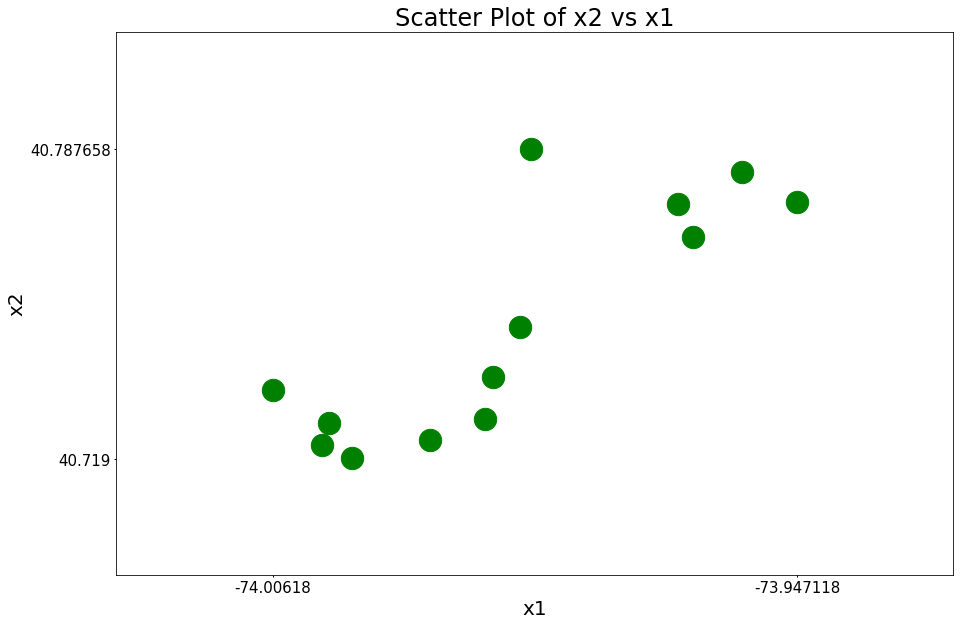

In [158]:
plot_points(figure_title='Scatter Plot of x2 vs x1')

Lets pick a random center.

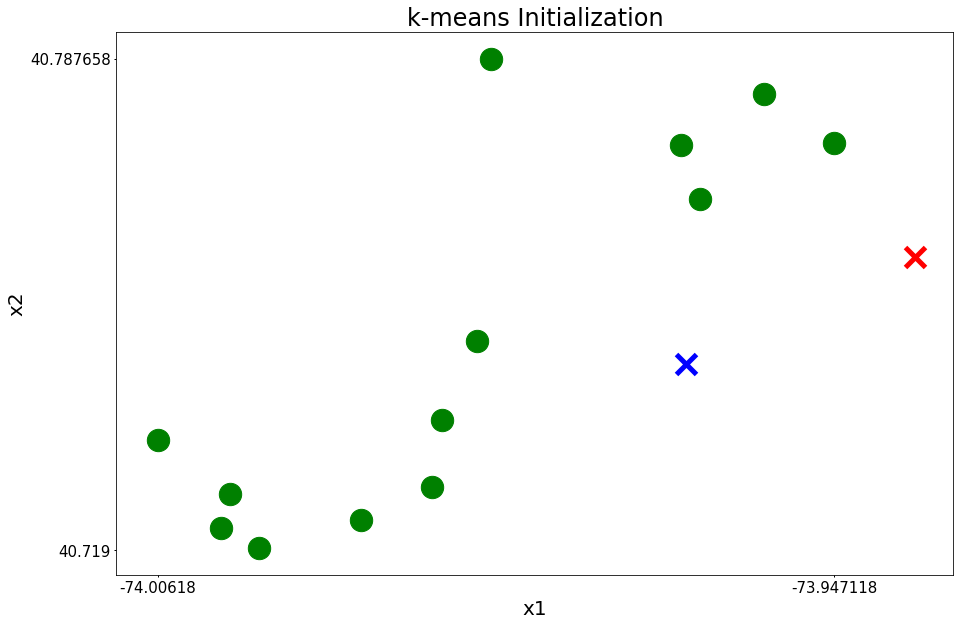

In [159]:
centers = [[-73.96, 40.745], [-73.94, 40.76]]
plot_points(centers, figure_title='k-means Initialization')

We now run 4 iterations to find the most convenient center.

Iteration 1 - Press Enter to update the members of each cluster 


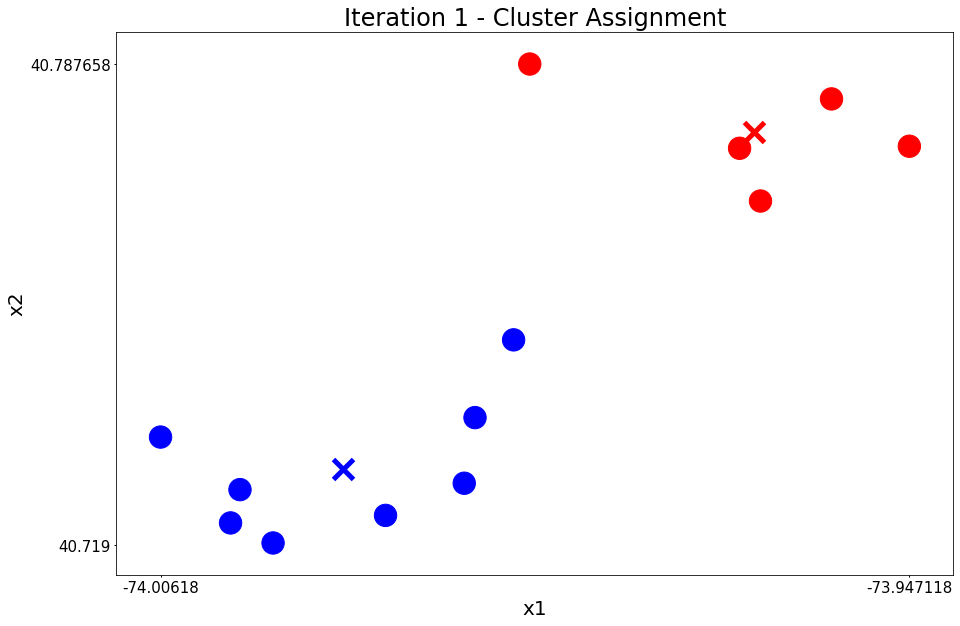

Iteration 1 - Press Enter to update the centers 


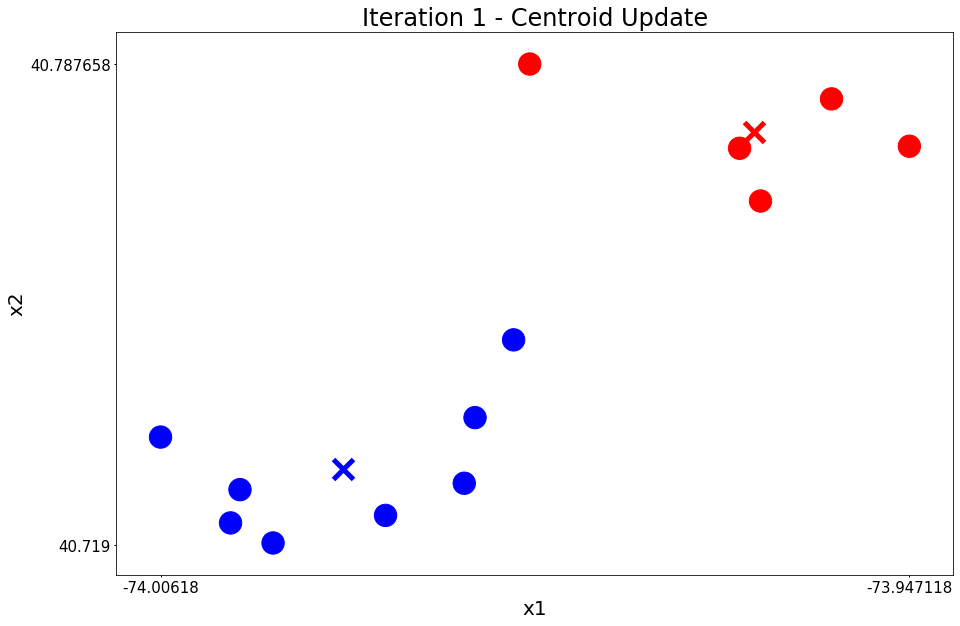

Iteration 2 - Press Enter to update the members of each cluster 


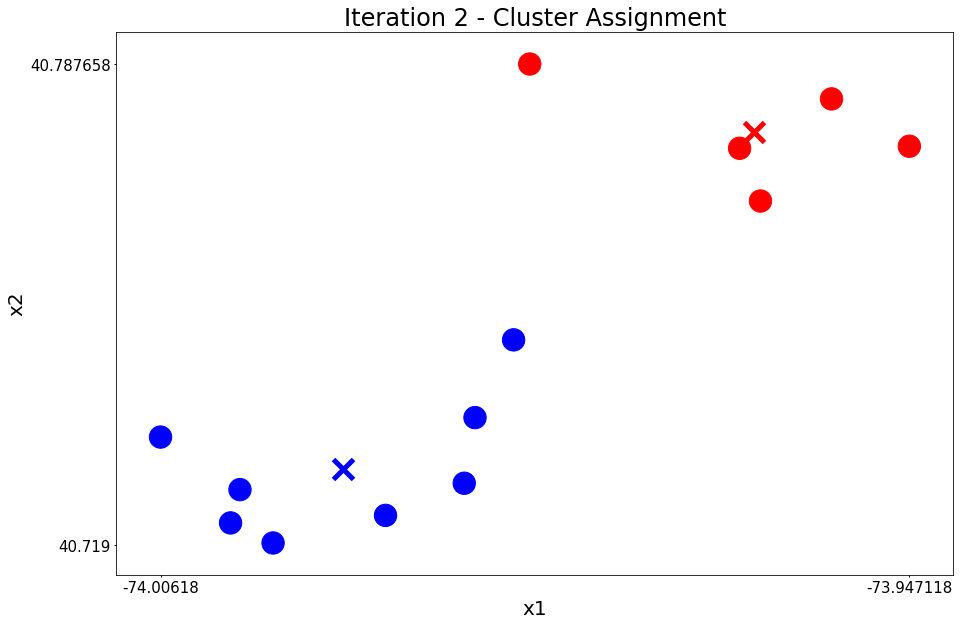

Iteration 2 - Press Enter to update the centers 


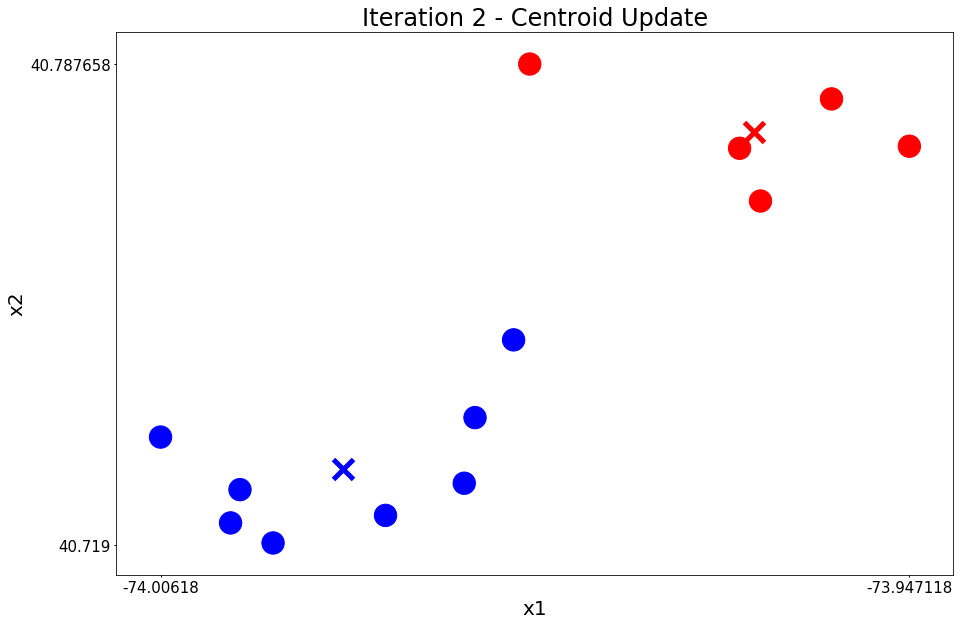

Iteration 3 - Press Enter to update the members of each cluster 


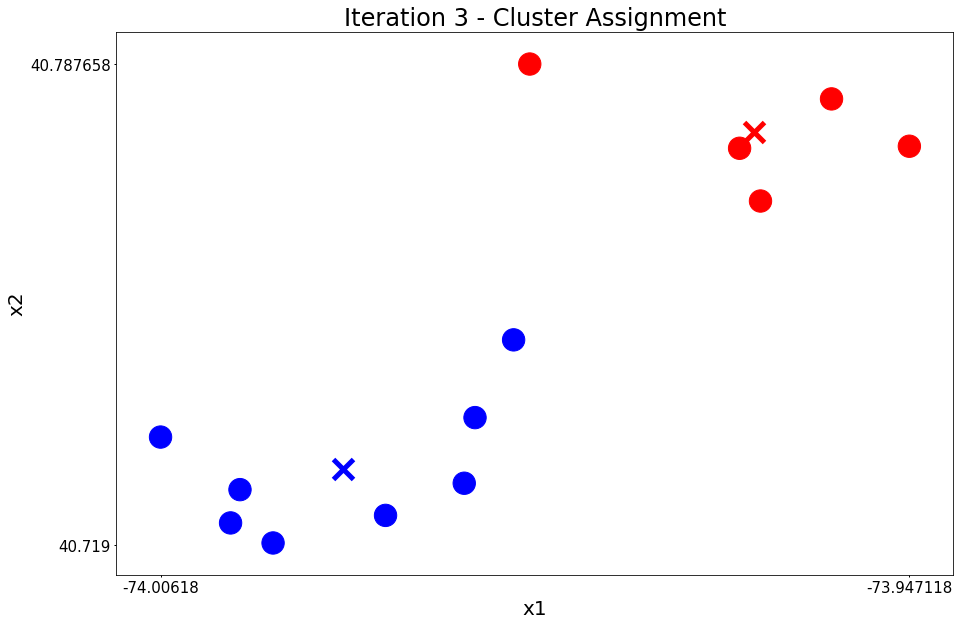

Iteration 3 - Press Enter to update the centers 


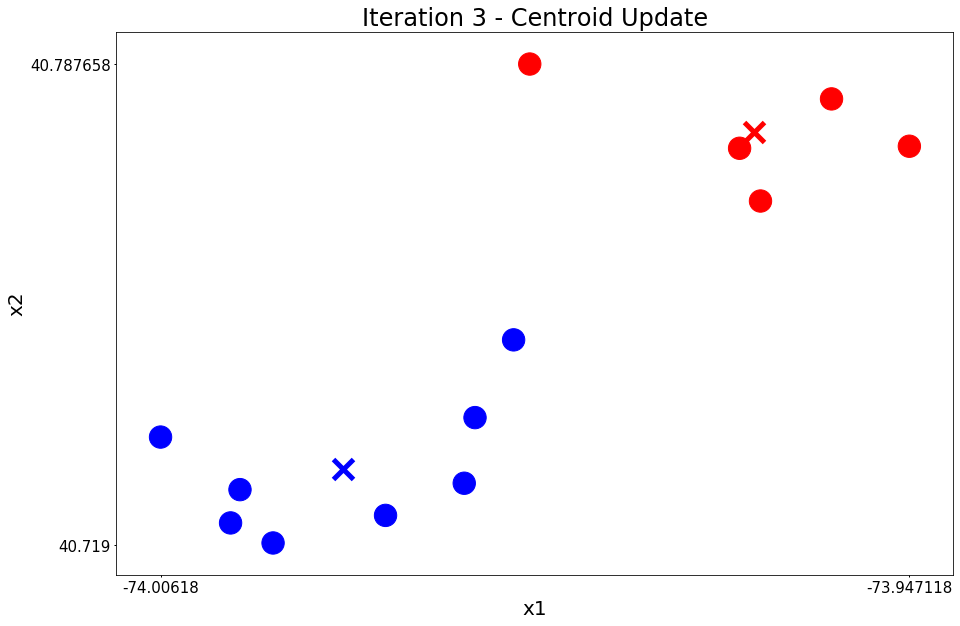

Iteration 4 - Press Enter to update the members of each cluster 


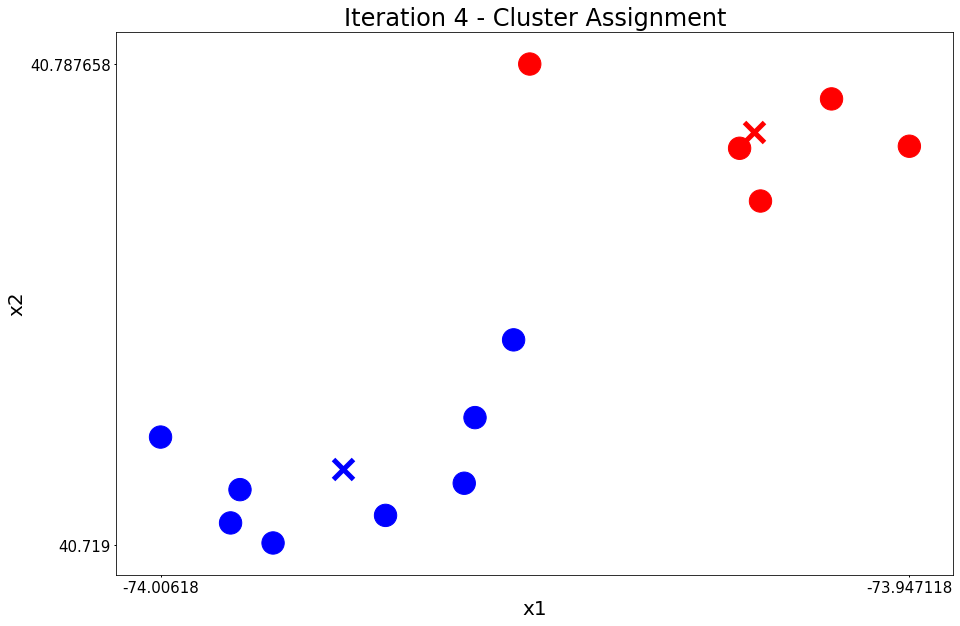

Iteration 4 - Press Enter to update the centers 


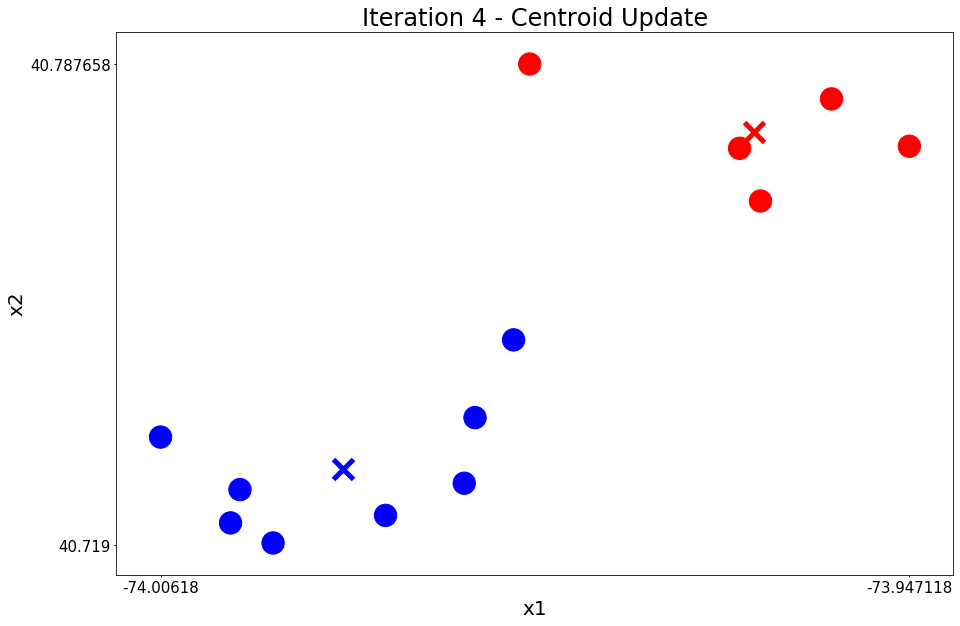

In [162]:
number_of_iterations = 4
for i in range(number_of_iterations):
    input('Iteration {} - Press Enter to update the members of each cluster'.format(i + 1))
    colors, class_of_points = assign_members(x1, x2, centers)
    title = 'Iteration {} - Cluster Assignment'.format(i + 1)
    plot_points(centers, colors, figure_title=title)
    input('Iteration {} - Press Enter to update the centers'.format(i + 1))
    centers = update_centers(x1, x2, class_of_points)
    title = 'Iteration {} - Centroid Update'.format(i + 1)
    plot_points(centers, colors, figure_title=title)

In [163]:
centers

[[-73.99180290316028, 40.72993664530722],
 [-73.95936017377662, 40.77800432942691]]

K-means has determined in 4 iterations the centers of our original now divided in 2 clusters

Lets visualize this on a map:

In [174]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1]['Latitude'], manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1]['Longitude'], manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1]['Neighborhood'], manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1]['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
# instantiate a mark centers object
centermark = plugins.MarkerCluster().add_to(map_clusters)
    
for i in range(len(centers)) :
    folium.Marker(
        location=[centers[i][1], centers[i][0]],
        icon=None,
        popup="Park here",
    ).add_to(centermark)
       
map_clusters

We have now determined the optimum places for the delivery man to wait for new orders. The addresses for these 2 points are:

In [165]:
geolocator = Nominatim(user_agent="NewYork")

In [166]:
location = geolocator.reverse("40.72993664530722, -73.99180290316028")
print(location)

FedEx, Astor Place, NoHo Historic District, NoHo, Manhattan Community Board 2, New York, Manhattan, New York County, New York, 10003, United States of America


In [167]:
location = geolocator.reverse("40.77800432942691, -73.95936017377662")
print(location)

69, East 82nd Street, Yorkville, New York, Manhattan Community Board 8, Manhattan, New York County, New York, 10028, United States of America


## Conclusion

This project reviewed the problem a third party delivery man faces when selecting the area with more orders opportunities. Based on data extracted from New York area, focused on Manhattan, we determined a cluster of neighborhoods with the most restaurants density according to Foursquare API, then we tried to propose the stand by spots based on those trending venues, unfortunately, due to Covid19 restaurants are temporarily closed and no trending data could be obtained, hence, an alternative approach is defined, standby spots were determined by K-means iterations of the selected cluster's venues. The result is 2 Standby spots that represent the perfect center of 2 restaurant clusters.